## Unzip finetuning files containing training scripts

In [1]:
!unzip finetuning.zip

Archive:  finetuning.zip
   creating: finetuning/evaluation/
   creating: finetuning/training/
   creating: finetuning/training/configs/
  inflating: finetuning/training/configs/chronos-t5-large.yaml  
  inflating: finetuning/training/configs/chronos-t5-small.yaml  
  inflating: finetuning/training/train.py  
  inflating: finetuning/evaluation/agg-relative-score.py  
  inflating: finetuning/evaluation/evaluate.py  
   creating: finetuning/evaluation/configs/
  inflating: finetuning/evaluation/configs/zero-shot.yaml  
  inflating: finetuning/evaluation/configs/in-domain.yaml  


## Install required packages

In [2]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git
!pip install "gluonts[torch]"
!pip install typer-config
!pip install triton

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-i7uas4u1
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-i7uas4u1
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 751f5f5f342d31249d6fea65fc0a4abd2f47d3c6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 10.1 MB/s eta 0:00:00
  Created wheel for chronos-forecasting: filename=chronos_forecasting-1.4.1-py3-none-any.whl size=28773 sha256=6ad602d59357a36a69525d075a881c8afef7b2e339978b215ddd39d041f512b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-vh3uemwd/wheels/bf/c1/65/08857e57345ef1b34ba0edb4791f1b2594943e82f34e93a4ab
Successfully built chronos-forecasting
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.1.

## Generate training and validation splits

In [27]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("Mastercard_stock_history.csv") # change file path as needed
df = df[["Date", "Close"]]
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
df = df.resample("D").ffill()

dates = df.index.to_numpy()
df = df[["Close"]]
df = df.to_numpy()

In [7]:
df = [df.squeeze()]

## Actual code

In [8]:
from pathlib import Path
from typing import List, Union

import numpy as np
from gluonts.dataset.arrow import ArrowWriter


def convert_to_arrow(
    path: Union[str, Path],
    time_series: Union[List[np.ndarray], np.ndarray],
    dates: np.ndarray,
    compression: str = "lz4",
):
    """
    Store a given set of series into Arrow format at the specified path.

    Input data can be either a list of 1D numpy arrays, or a single 2D
    numpy array of shape (num_series, time_length).
    """
    assert isinstance(time_series, list) or (
        isinstance(time_series, np.ndarray) and
        time_series.ndim == 2
    )

    start = dates[0]

    dataset = [
        {"start": start, "target": ts} for ts in time_series
    ]

    ArrowWriter(compression=compression).write_to_file(
        dataset,
        path=path,
    )


if __name__ == "__main__":
    time_series = df

    # Convert to GluonTS arrow format
    convert_to_arrow("./mastercard.arrow", time_series=df, dates=dates)

In [9]:
!CUDA_VISIBLE_DEVICES=0 python ./finetuning/training/train.py --config ./finetuning/training/configs/chronos-t5-small.yaml

2024-12-16 02:01:45.275306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-16 02:01:45.294875: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-16 02:01:45.300686: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-16 02:01:45.314771: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-16 02:01:46.451883: W tensorflow/comp

Seed used for the above process was: 3027287740

Zip the finetuning files modified in this run

In [10]:
!zip -r finetuning.zip finetuning

updating: finetuning/evaluation/ (stored 0%)
updating: finetuning/training/ (stored 0%)
updating: finetuning/ (stored 0%)
updating: finetuning/training/configs/ (stored 0%)
updating: finetuning/training/configs/chronos-t5-large.yaml (deflated 40%)
updating: finetuning/training/configs/chronos-t5-small.yaml (deflated 39%)
updating: finetuning/training/train.py (deflated 71%)
updating: finetuning/evaluation/agg-relative-score.py (deflated 63%)
updating: finetuning/evaluation/evaluate.py (deflated 68%)
updating: finetuning/evaluation/configs/ (stored 0%)
updating: finetuning/evaluation/configs/zero-shot.yaml (deflated 86%)
updating: finetuning/evaluation/configs/in-domain.yaml (deflated 81%)


## Save model to huggingface

In [12]:
!pip install huggingface_hub

In [13]:
from huggingface_hub import notebook_login

notebook_login() # need to create an API key first

In [14]:
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained("./output/run-0/checkpoint-2000")
pipeline.model.model.push_to_hub("chronos-t5-small-fine-tuned")

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Jiahao123/chronos-t5-small-fine-tuned/commit/8c512c5286d02cdeea6280384f86a3225bbf9618', commit_message='Upload T5ForConditionalGeneration', commit_description='', oid='8c512c5286d02cdeea6280384f86a3225bbf9618', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Jiahao123/chronos-t5-small-fine-tuned', endpoint='https://huggingface.co', repo_type='model', repo_id='Jiahao123/chronos-t5-small-fine-tuned'), pr_revision=None, pr_num=None)

## Evalute on test data

In [23]:
train_df = pd.read_csv("Mastercard_stock_history.csv")
test_df = pd.read_csv("Mastercard_test.csv")[:100]

In [24]:
test_df.head()

,Date,Open,High,Low,Close,Volume
0,12/10/2021 16:00:00,348.65,350.00,344.62,345.34,3042883
1,13/10/2021 16:00:00,346.25,349.50,336.98,342.35,3755921
2,14/10/2021 16:00:00,343.84,345.81,340.83,344.58,4085934
3,15/10/2021 16:00:00,349.00,356.61,347.74,356.00,4053607
4,18/10/2021 16:00:00,353.96,359.94,350.23,358.44,3280888


In [18]:
# load model from huggingface hub
pipeline = ChronosPipeline.from_pretrained("Jiahao123/chronos-t5-small-fine-tuned")

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [22]:
context = torch.tensor(train_df["Close"])
prediction_length = 100 # make 100 days of predictions
forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

In [25]:
forecast_index = range(len(train_df), len(train_df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

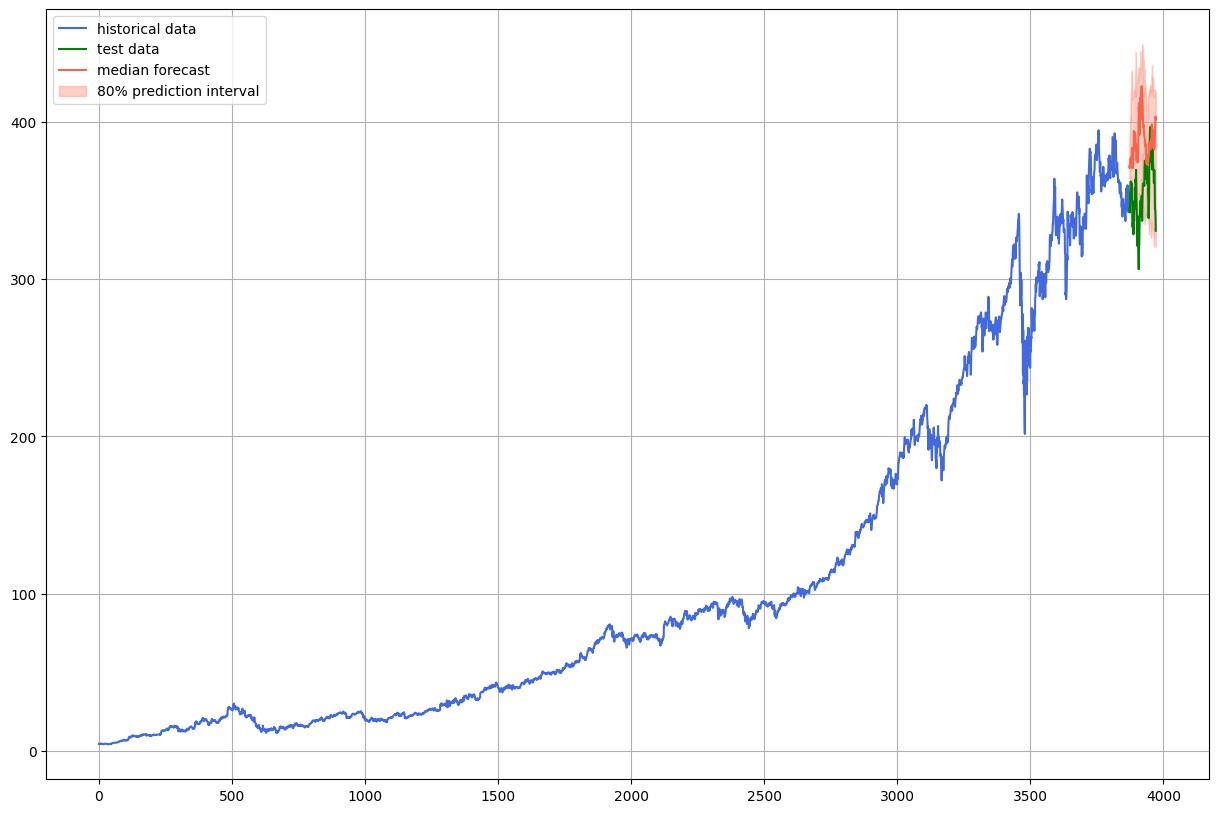

In [32]:
plt.figure(figsize=(15, 10))
plt.plot(train_df["Close"], color="royalblue", label="historical data")
plt.plot(forecast_index, test_df["Close"], color = "green", label = "test data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

In [33]:
# compute mean squared error metric
# use median value to calculate RMSE
mse = np.mean((test_df["Close"] - median)**2)
print(f"RMSE is: {np.sqrt(mse): .2f}")

RMSE is:  41.22


## Compare RMSE against original model

In [34]:
# load model from huggingface hub
pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-small")

config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [35]:
context = torch.tensor(train_df["Close"])
prediction_length = 100 # make 100 days of predictions
forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

forecast_index = range(len(train_df), len(train_df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

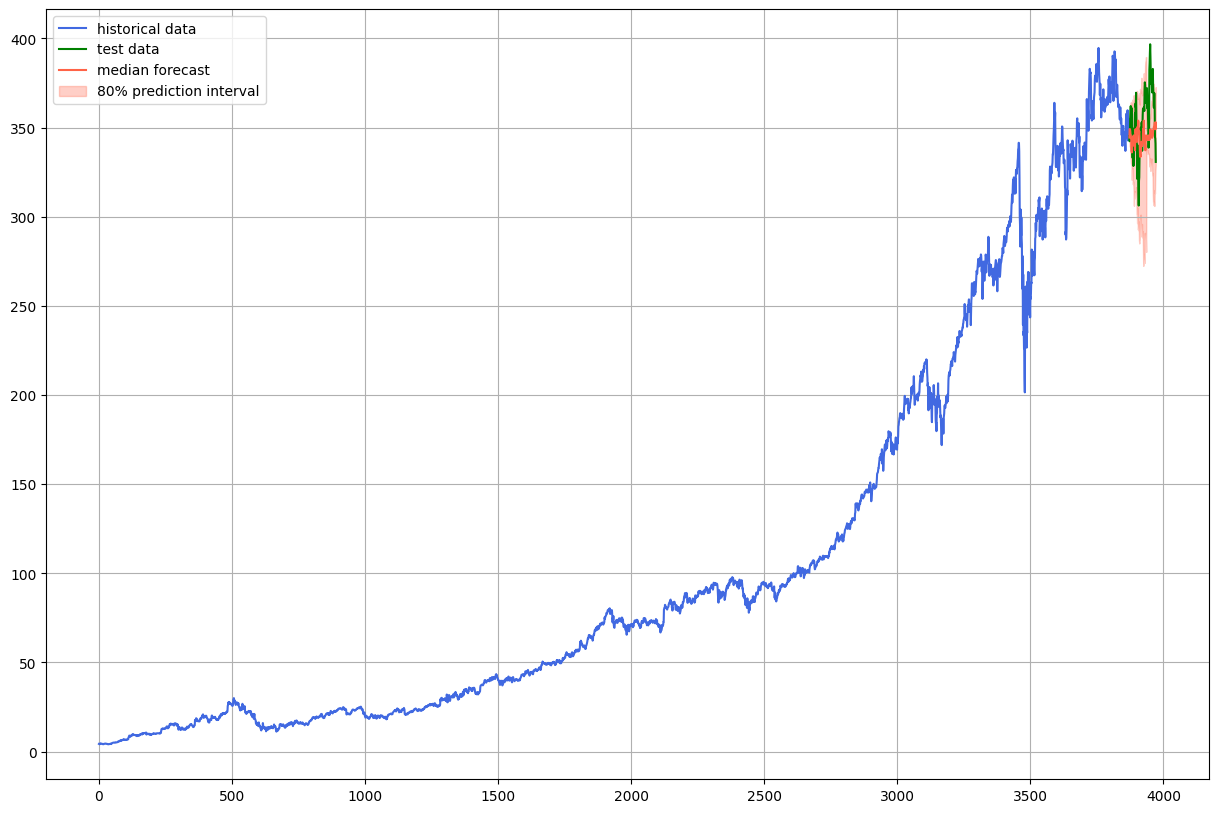

In [36]:
plt.figure(figsize=(15, 10))
plt.plot(train_df["Close"], color="royalblue", label="historical data")
plt.plot(forecast_index, test_df["Close"], color = "green", label = "test data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

In [37]:
# compute mean squared error metric
# use median value to calculate RMSE
mse = np.mean((test_df["Close"] - median)**2)
print(f"RMSE is: {np.sqrt(mse): .2f}")

RMSE is:  21.19


RMSE increased after finetuning, check loss function and whether there was overfitting